In [111]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import matplotlib.pyplot as plt
%matplotlib inline

In [112]:
import csv
import pymongo
import pprint
import sys, getopt
from bson.objectid import ObjectId
from pymongo import MongoClient
import re

In [149]:
connection = pymongo.MongoClient("mongodb://127.0.0.1:27017/?compressors=disabled&gssapiServiceName=mongodb")
mydb= connection.PreProcessor
mycol = mydb["Data_Cleaning"]
mycol_clean = mydb["Data_clean_after_analysis"]
mycol.drop()
mycol_clean.drop()
mydb.segment.drop()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymongo/compression_support.py:59: UserWarning: Unsupported compressor: disabled
  warnings.warn("Unsupported compressor: %s" % (compressor,))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymongo/common.py:797: UserWarning: Unknown option gssapiservicename
  warnings.warn(str(exc))


In [150]:
with open('tweets.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = csv.DictReader(read_obj)
    # Pass reader object to list() to get a list of lists
    mylist = list(csv_reader)
    #print(list_of_rows)
    x_list = mycol.insert_many(mylist)

    #print list of the _id values of the inserted documents:

In [151]:
airline_tweets= pd.DataFrame(list(mycol.find()))

<AxesSubplot:ylabel='airline'>

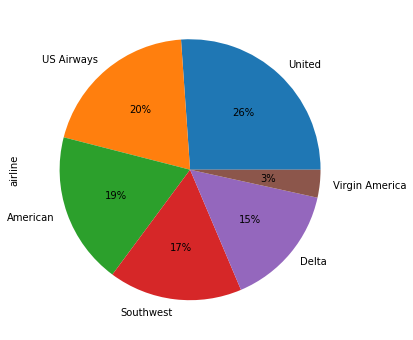

In [152]:
airline_tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

<AxesSubplot:ylabel='airline_sentiment'>

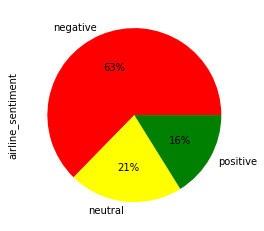

In [117]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

<AxesSubplot:xlabel='airline'>

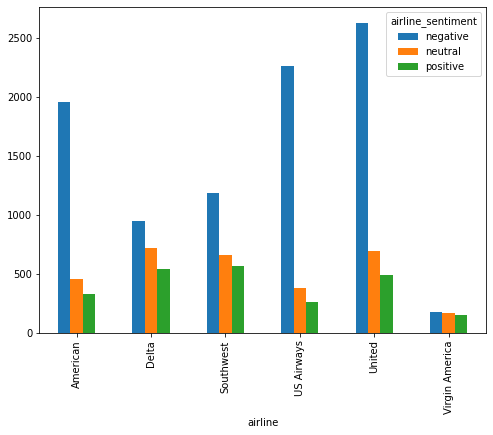

In [153]:
airline_sentiment = airline_tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

In [154]:
with open('tweets.csv', 'r') as read_obj_clean:
    # pass the file object to reader() to get the reader object
    csv_reader_clean = csv.DictReader(read_obj_clean)
    # Pass reader object to list() to get a list of lists
    mylist_clean = list(csv_reader_clean)
    #print(list_of_rows)
    y = mycol_clean.insert_many(mylist_clean)


In [178]:
mycol_clean.update_many({}, {'$unset': {'airline': 1, 'airline_sentiment_confidence' : 1, 'airline_sentiment_gold': 1, 'negativereason': 1, 'negativereason_gold': 1, 'tweet_coord': 1, 'tweet_created': 1, "tweet_location": 1, 'name' : 1,'retweet_count': 1, "negativereason_confidence": 1 , 'user_timezone': 1, 'tweet_id' : 1}})

In [179]:
pprint.pprint(mycol_clean.find_one())

{'_id': ObjectId('62e2b18018ee668c5fcf22ed'),
 'airline_sentiment': 'neutral',
 'text': 'virginamerica what dhepburn said'}


In [180]:
for doc in mycol_clean.find(no_cursor_timeout=True):
            pk = ObjectId(str(doc.get("_id")))
            t = doc.get('text')
            if t:
               t = t.lower()
               t = t.replace("'ve"," have")
               t = t.replace("didn't","did not")
               t = t.replace("can't","cannot")
               t = t.replace("haven't","have not")
               t = t.replace("'re"," are") 
               t = t.replace("im","i am")
               t = t.replace("wont","will not")
               t = t.replace("couldn't","could not")
               t = t.replace("❤️","love")
               t = t.replace("☺️","happy")
               t = t.replace("👍","good job")
               t = re.sub('[0-9]', '', t)
            special_char = '!@#$%^&*()[]{};:,./<>?\|`~-=_+'
            for i in special_char:
                t = t.replace(i, '')
               
            mycol_clean.update_one({"_id": pk}, {"$set":{"text":t}}) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymongo/collection.py:1643: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://mongodb.com/docs/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout-overrides-nocursortimeout
  return Cursor(self, *args, **kwargs)


In [181]:
tweets_Analysis_clean= pd.DataFrame(list(mycol_clean.find()))

In [182]:
tweets_Analysis_clean.head()

,_id,airline_sentiment,text
0,62e2b18018ee668c5fcf22ed,neutral,virginamerica what dhepburn said
1,62e2b18018ee668c5fcf22ee,positive,virginamerica plus you have added commercials ...
2,62e2b18018ee668c5fcf22ef,neutral,virginamerica i did not today must mean i need...
3,62e2b18018ee668c5fcf22f0,negative,virginamerica it's really aggressive to blast ...
4,62e2b18018ee668c5fcf22f1,negative,virginamerica and it's a really big bad thing ...


In [183]:
plot_size = plt.rcParams["figure.figsize"] 
print(plot_size[0]) 
print(plot_size[1])

plot_size[0] = 8
plot_size[1] = 6
plt.rcParams["figure.figsize"] = plot_size 

8.0
6.0


In [184]:
features = tweets_Analysis_clean.iloc[:, 2].values
labels = tweets_Analysis_clean.iloc[:, 1].values

In [186]:
processed_features = []

for sentence in range(0, len(features)):
    processed_features.append(str(features[sentence]))

In [187]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

In [188]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
processed_features = vectorizer.fit_transform(processed_features).toarray()

In [189]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_features, labels, test_size=0.2, random_state=0)

In [190]:
from sklearn.ensemble import RandomForestClassifier

text_classifier = RandomForestClassifier(n_estimators=200, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [191]:
predictions = text_classifier.predict(X_test)

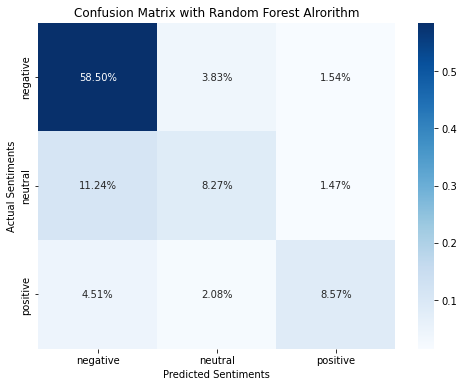

Classification Report with Random Forest Alrorithm
--------------------------------------------------
              precision    recall  f1-score   support

    negative       0.79      0.92      0.85      1870
     neutral       0.58      0.39      0.47       614
    positive       0.74      0.57      0.64       444

    accuracy                           0.75      2928
   macro avg       0.70      0.63      0.65      2928
weighted avg       0.74      0.75      0.74      2928

Accuracy Score: 
0.7534153005464481


In [195]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

cf_matrix = confusion_matrix(y_test,predictions)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive'])
ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive'])
ax.set_title('Confusion Matrix with Random Forest Alrorithm');
ax.set_xlabel('Predicted Sentiments')
ax.set_ylabel('Actual Sentiments');
plt.show()

print('Classification Report with Random Forest Alrorithm')
print(classification_report(y_test,predictions))
print('Accuracy Score: ')
print(accuracy_score(y_test, predictions))

In [134]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr')
LR.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(multi_class='ovr', random_state=0)

In [146]:
predictions = LR.predict(X_test)

In [136]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[6958  320   98]
 [ 785 1522  155]
 [ 341  168 1365]]
              precision    recall  f1-score   support

    negative       0.86      0.94      0.90      7376
     neutral       0.76      0.62      0.68      2462
    positive       0.84      0.73      0.78      1874

    accuracy                           0.84     11712
   macro avg       0.82      0.76      0.79     11712
weighted avg       0.84      0.84      0.84     11712

0.8405908469945356


In [137]:
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=5)
KNN.fit(X_train, y_train)

KNeighborsClassifier()

In [138]:
predictions = KNN.predict(X_test)

In [139]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[6364  734  278]
 [ 291 2003  168]
 [ 210  236 1428]]
              precision    recall  f1-score   support

    negative       0.93      0.86      0.89      7376
     neutral       0.67      0.81      0.74      2462
    positive       0.76      0.76      0.76      1874

    accuracy                           0.84     11712
   macro avg       0.79      0.81      0.80     11712
weighted avg       0.85      0.84      0.84     11712

0.8363217213114754


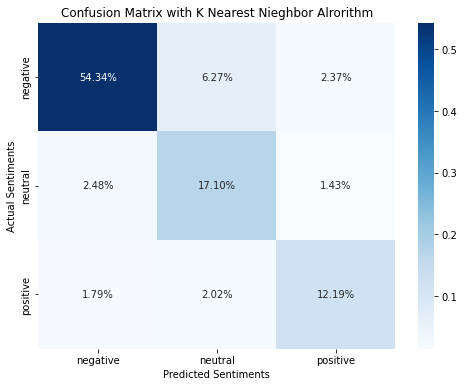

In [140]:
import seaborn as sns
cf_matrix = confusion_matrix(y_test,predictions)
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive'])
ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive'])
ax.set_title('Confusion Matrix with K Nearest Nieghbor Alrorithm');
ax.set_xlabel('Predicted Sentiments')
ax.set_ylabel('Actual Sentiments');
plt.show()

In [141]:
def predict_sentiment(text):
    s_features = []
    s_features.append(text)
    testvect = vectorizer.transform(s_features).toarray()
    s_prediction = text_classifier.predict(testvect)
    return s_prediction[0]

In [142]:
predict_sentiment("I hate the work you did")

'negative'

In [143]:
import pickle
pickle.dump(LR, open('model.pkl', 'wb'))

In [144]:
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))